<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Format" data-toc-modified-id="Format-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#Dataset-subsampling" data-toc-modified-id="Dataset-subsampling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dataset subsampling</a></span></li><li><span><a href="#cooccur()" data-toc-modified-id="cooccur()-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><code>cooccur()</code></a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Variance-among-dataset-subsets" data-toc-modified-id="Variance-among-dataset-subsets-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Variance among dataset subsets</a></span></li></ul></li><li><span><a href="#Summarizing-results" data-toc-modified-id="Summarizing-results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Summarizing results</a></span><ul class="toc-item"><li><span><a href="#Formatting" data-toc-modified-id="Formatting-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Formatting</a></span><ul class="toc-item"><li><span><a href="#effect-sizes" data-toc-modified-id="effect-sizes-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>effect sizes</a></span><ul class="toc-item"><li><span><a href="#Saving-results" data-toc-modified-id="Saving-results-8.1.1.1"><span class="toc-item-num">8.1.1.1&nbsp;&nbsp;</span>Saving results</a></span></li><li><span><a href="#Formatting" data-toc-modified-id="Formatting-8.1.1.2"><span class="toc-item-num">8.1.1.2&nbsp;&nbsp;</span>Formatting</a></span></li></ul></li><li><span><a href="#Probability-table" data-toc-modified-id="Probability-table-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Probability table</a></span></li><li><span><a href="#Determining-significance" data-toc-modified-id="Determining-significance-8.1.3"><span class="toc-item-num">8.1.3&nbsp;&nbsp;</span>Determining significance</a></span></li><li><span><a href="#Taxonomy" data-toc-modified-id="Taxonomy-8.1.4"><span class="toc-item-num">8.1.4&nbsp;&nbsp;</span>Taxonomy</a></span></li></ul></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Normalizing-by-number-of-nodes" data-toc-modified-id="Normalizing-by-number-of-nodes-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Normalizing by number of nodes</a></span></li><li><span><a href="#Combined-table" data-toc-modified-id="Combined-table-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Combined table</a></span></li></ul></li><li><span><a href="#Saving-network" data-toc-modified-id="Saving-network-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Saving network</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Run `cooccur()` analysis on bacteria (from uni-primers) & archaea (from arch-primers)
  * binomial (pres/abs) abundances
  * intra-species variation sensitivity analysis (1 sampler per species)

# Var

In [17]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# params
sparsity_cutoff = 0.05
qval_cutoff = 0.05
threads = 12

# Init

In [26]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
library(networkD3)
library(cooccur)
library(future.batchtools)
library(future.apply)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 

In [7]:
# slower wait interval
options(future.wait.interval = 2.0)

In [8]:
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur/ 


# Load

In [9]:
# phyloseq object (binomial)
physeq = readRDS(physeq_file) %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) %>%
    transform_sample_counts(function(x) ifelse(x > 0, 1, 0)) 
    
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [11]:
# metadata
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    dplyr::select(X.SampleID, scientific_name, class, order, family, genus, diet)

metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213   7


,X.SampleID,scientific_name,class,order,family,genus,diet
X1.Eurasian.Beaver,X1.Eurasian.Beaver,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor,herbivore
X101.Horse,X101.Horse,Equus_caballus,Mammalia,Perissodactyla,Equidae,Equus,herbivore
X102.Kulan,X102.Kulan,Equus_hemionus,Mammalia,Perissodactyla,Equidae,Equus,herbivore


# Format

In [12]:
otu = physeq %>%
    otu_table %>%
    as.matrix %>%
    as.data.frame 

otu %>% dfhead

[1] 408 213


,X1.Eurasian.Beaver,X101.Horse,X102.Kulan,X109.Red.Fox,X110.Noctule,X111.West.European.Hedgehog,X116.Common.Kestrel,X122.Wild.Boar,X123.Alpine.Chamois,X124.Golden.Jackal,⋯,F45.Red.Deer,F47.Red.Deer,F48.Red.Deer,F53.Mouflon,F66.Wild.Boar,F68.Red.Deer,F69.Red.Deer,F70.Red.Deer,F80.Red.Deer,F90.Domestic.Dog
368bd5c2255f3a5ce0fef06ca6de1d04,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
779324e5648460c5a67e577c45131b42,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
b918d185ee89a0b33d821ee766d76eb3,0,0,0,0,0,0,0,0,0,0,⋯,1,1,1,1,0,1,1,1,1,0


# Dataset subsampling

In [13]:
# number of permutated SpecD datasetst
nperm_datasets = 100

In [19]:
#' randomly selecting one per group
#' L : list of distance matrixes used for MRM
#' df_grps : data.frame (sample, group)
one_per_group = function(rep, otu, df_grps, ...){
    # get subsample
    colnames(df_grps) = c('Sample', 'Group')
    df_grps = df_grps %>%
        group_by(Group) %>%
        sample_n(1) %>%
        ungroup()
    # subsetting
    otu = otu[,df_grps$Sample]
    otu = otu[rowSums(otu) > 0,]
    return(otu)
}

In [15]:
# grouping samples by species
df_grps = metadata %>% 
    dplyr::select(X.SampleID, scientific_name)
df_grps %>% dfhead

[1] 213   2


,X.SampleID,scientific_name
X1.Eurasian.Beaver,X1.Eurasian.Beaver,Castor_fiber
X101.Horse,X101.Horse,Equus_caballus
X102.Kulan,X102.Kulan,Equus_hemionus


In [20]:
# creating subset datasets
doParallel::registerDoParallel(threads)
x = as.list(1:nperm_datasets)
otu_l = plyr::llply(x, one_per_group, otu=otu, df_grps=df_grps, .parallel=TRUE)

# status
otu_l %>% length %>% print
otu_l %>% lapply(ncol) %>% unlist %>% summary %>% print
otu_l[[1]] %>% dfhead

[1] 100
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    128     128     128     128     128     128 
[1] 408 128


,X350.Smooth.Newt,X357.Northern.Tamandua,X237.Red.shanked.Douc.Langur,X19.European.Ground.Squirrel,X403.Chacma.Baboon,X335.Harbor.Seal,X337.Sowerbys.Beaked.Whale,X190.Common.House.Gecko,X110.Noctule,X228.Domestic.Cat,⋯,X423.Quagga,X419.African.Buffalo,X418.Giraffe,X96.European.Hare,X1.Eurasian.Beaver,X431.Quagga,X266.Western.Marsh.Harrier,F70.Red.Deer,X351.Grass.Snake,X414.Vervet.Monkey
368bd5c2255f3a5ce0fef06ca6de1d04,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
779324e5648460c5a67e577c45131b42,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
b918d185ee89a0b33d821ee766d76eb3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


# `cooccur()`

In [27]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '20G',
                 threads = '1',
                 conda.env = "py3_physeq_eco",
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)

In [28]:
# Running cooccur() in parallel on each dataset subset
## WARNING: SLOW
cooccur_res = future_lapply(otu_l, 
                            FUN = cooccur, 
                            type="spp_site", 
                            thresh=TRUE, 
                            spp_names=TRUE,
                            future.packages=c('cooccur'))

cooccur_res %>% length

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

[1] 100

In [29]:
# checking result
cooccur_res %>% length

[1] 100

## Saving results

In [30]:
# output file name
cooccur_res_file = file.path(work_dir, 'IndD-sens_OTU-cooccur.RDS')
cooccur_res_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-cooccur.RDS"

In [31]:
# saving
saveRDS(cooccur_res, file=cooccur_res_file)
cat('File written:', cooccur_res_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-cooccur.RDS 


In [32]:
# loading
cooccur_res = readRDS(cooccur_res_file)
cooccur_res %>% length

[1] 100

In [33]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/5_assembly/cooccur/02_IndD-sens_OTU-binom.ipynb')

## Variance among dataset subsets

In [34]:
summary_all = function(x){
    x = as.list(summary(x))
    c(Positive=x$Positive, Negative=x$Negative, 
      Random=x$Random, Unclassifiable=x$Unclassifiable)
}

In [35]:
cooccur_res_s = lapply(cooccur_res, summary_all) %>% 
    do.call(rbind, .) %>%
    as.data.frame

Call:
...future.FUN(mat = ...future.X_jj, type = "spp_site", thresh = TRUE, 
    spp_names = TRUE)

Of 83028 species pair combinations, 77214 pairs (93 %) were removed from the analysis because expected co-occurrence was < 1 and 5814 pairs were analyzed

Cooccurrence Summary:
Call:
...future.FUN(mat = ...future.X_jj, type = "spp_site", thresh = TRUE, 
    spp_names = TRUE)

Of 83028 species pair combinations, 75106 pairs (90.46 %) were removed from the analysis because expected co-occurrence was < 1 and 7922 pairs were analyzed

Cooccurrence Summary:
Call:
...future.FUN(mat = ...future.X_jj, type = "spp_site", thresh = TRUE, 
    spp_names = TRUE)

Of 83028 species pair combinations, 77556 pairs (93.41 %) were removed from the analysis because expected co-occurrence was < 1 and 5472 pairs were analyzed

Cooccurrence Summary:
Call:
...future.FUN(mat = ...future.X_jj, type = "spp_site", thresh = TRUE, 
    spp_names = TRUE)

Of 83028 species pair combinations, 73114 pairs (88.06 %) were 

limit_output extension: Maximum message size of 20000 exceeded with 28007 characters

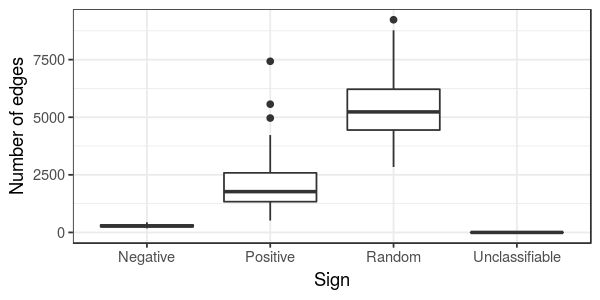

In [36]:
cooccur_res_s$rep = 1:nrow(cooccur_res_s)
cooccur_res_s = cooccur_res_s %>%
    gather(variable, value, -rep) %>%
    mutate(value = value %>% as.Num)

p = ggplot(cooccur_res_s, aes(variable, value)) +
    geom_boxplot() +
    labs(x='Sign', y='Number of edges') +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=2.5)
plot(p)

# Summarizing results

## Formatting

### effect sizes

In [37]:
# output file name
effect_size_file = file.path(work_dir, 'IndD-sens_OTU-cooccur_effectSizes.RDS')
effect_size_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-cooccur_effectSizes.RDS"

In [44]:
# cluster resources
resources = list(h_rt = '24:00:00',
                 h_vmem = '20G',
                 threads = '1',
                 conda.env = "py3_physeq_eco",
                 conda.path = "/ebio/abt3_projects/software/miniconda3_gt4.4/bin")
plan(batchtools_sge, resources=resources)


In [65]:
# getting globals (needed because "cooccur_res" is a list of cooccur objects)
globals_X = lapply(cooccur_res, FUN = getGlobalsAndPackages)
names(globals_X) = gsub('^', 'ID', 1:length(globals_X))
globals_X %>% class

[1] "list"

In [66]:
# Running cluster jobs
## WARNING: SLOW
#cooccur_res
cooccur_res_es = future_lapply(cooccur_res, 
                               FUN=effect.sizes,
                               future.globals=globals_X,
                               future.packages=c('cooccur'))

cooccur_res_es %>% length

Warning message in delete.BatchtoolsFuture(future, onRunning = "skip", onMissing = "ignore", :
“Will not remove batchtools registry, because the status of the batchtools was ‘error’ and option 'future.delete' is FALSE or running in an interactive session: ‘/ebio/abt3_projects/Georg_animal_feces/notebooks/16S/5_assembly/cooccur/.future/20180809_100209-jGmOuL/batchtools_625787374’”Warning message in delete.BatchtoolsFuture(future, onRunning = "skip", onMissing = "ignore", :
“Will not remove batchtools registry, because the status of the batchtools was ‘error’ and option 'future.delete' is FALSE or running in an interactive session: ‘/ebio/abt3_projects/Georg_animal_feces/notebooks/16S/5_assembly/cooccur/.future/20180809_100209-jGmOuL/batchtools_2065825056’”Warning message in delete.BatchtoolsFuture(future, onRunning = "skip", onMissing = "ignore", :
“Will not remove batchtools registry, because the status of the batchtools was ‘error’ and option 'future.delete' is FALSE or running in an 

[1] 100

#### Saving results

In [67]:
# saving
saveRDS(cooccur_res_es, file=effect_size_file)
cat('File written:', effect_size_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-cooccur_effectSizes.RDS 


In [68]:
# loading
cooccur_res_es = readRDS(effect_size_file)
cooccur_res_es %>% length

[1] 100

In [69]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/5_assembly/cooccur/02_IndD-sens_OTU-binom.ipynb')

#### Formatting

In [70]:
# number of datset reps where the edge occurs
do.call(rbind, cooccur_res_es) %>%
    group_by(sp1, sp2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    .$n %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00   11.00   29.28   50.00  100.00 

In [71]:
# adding rep; combining into 1 df; summarizing
cooccur_res_es = do.call(rbind, cooccur_res_es) %>%
    group_by(sp1, sp2) %>%
    summarize(sd_effects = sd(effects, na.rm=TRUE),
              effects = mean(effects, na.rm=TRUE)) %>%
    ungroup()

cooccur_res_es %>% dfhead

[1] 26848     4


sp1,sp2,sd_effects,effects
368bd5c2255f3a5ce0fef06ca6de1d04,13fabb2c42c260bd77b4358f429eba6c,0.001776308,0.002257812
368bd5c2255f3a5ce0fef06ca6de1d04,bfc2bdf08b075d249213e99de23e532c,0.002800374,-0.023750000
368bd5c2255f3a5ce0fef06ca6de1d04,ab6bc0116bcfefcbeb981d83cd525034,0.001939012,-0.017218750


In [72]:
# summary
cooccur_res_es$effects %>% summary %>% print
cooccur_res_es$sd_effects %>% summary %>% print

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.100695 -0.008482 -0.006410  0.018860  0.056510  0.097039 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.001   0.001   0.002   0.004   0.016    5015 


### Probability table

In [73]:
#' getting prob table
cooccur_res_pt = lapply(cooccur_res, function(x) prob.table(x)) 
cooccur_res_pt %>% length 

Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not incl

“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning message in prob.table(x):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”Warning mess

[1] 100

In [74]:
# adding rep & combining into 1 df
cooccur_res_pt = lapply(as.list(1:length(cooccur_res_pt)),
       function(x){ cooccur_res_pt[[x]]$rep = x; return(cooccur_res_pt[[x]])}) %>%
    do.call(rbind, .) 

cooccur_res_pt %>% dfhead

[1] 786197     12


sp1,sp2,sp1_inc,sp2_inc,obs_cooccur,prob_cooccur,exp_cooccur,p_lt,p_gt,sp1_name,sp2_name,rep
1,10,8,26,2,0.013,1.6,0.79532,0.51078,368bd5c2255f3a5ce0fef06ca6de1d04,13fabb2c42c260bd77b4358f429eba6c,1
1,11,8,46,0,0.022,2.9,0.02493,1.00000,368bd5c2255f3a5ce0fef06ca6de1d04,bfc2bdf08b075d249213e99de23e532c,1
1,13,8,32,0,0.016,2.0,0.09275,1.00000,368bd5c2255f3a5ce0fef06ca6de1d04,ab6bc0116bcfefcbeb981d83cd525034,1


### Determining significance

In [75]:
# summarizing across subsample reps; how many significant edges?
cooccur_res_pt_s = cooccur_res_pt %>%
    group_by(rep) %>%
    mutate(q_gt = p.adjust(p_gt, method='BH'),
           q_lt = p.adjust(p_lt, method='BH')) %>%
    ungroup() %>%
    group_by(sp1_name, sp2_name) %>%
    summarize(obs_cooccur = mean(obs_cooccur, na.rm=TRUE),
              prob_cooccur = mean(prob_cooccur, na.rm=TRUE),
              exp_cooccur = mean(exp_cooccur, na.rm=TRUE),
              q_gt = (nperm_datasets - sum(q_gt < qval_cutoff)) / nperm_datasets,
              q_lt = (nperm_datasets - sum(q_lt < qval_cutoff)) / nperm_datasets,
              sign = ifelse(q_gt < qval_cutoff, 1, 0) + ifelse(q_lt < qval_cutoff, -1, 0)
             ) %>%
    ungroup()

# status
cooccur_res_pt_s$sign %>% table %>% print
cooccur_res_pt_s %>% dfhead

.
   -1     0     1 
    1 26607   240 
[1] 26848     8


sp1_name,sp2_name,obs_cooccur,prob_cooccur,exp_cooccur,q_gt,q_lt,sign
003c4ae8c3fbf5aee27b58e6b7fd5e10,0215b7637847641274246f9414d2b649,0,0.008870968,1.124194,1.00,1,0
003c4ae8c3fbf5aee27b58e6b7fd5e10,09aa18b6829bdca56e6f9aff75f581dd,0,0.008675676,1.097297,1.00,1,0
003c4ae8c3fbf5aee27b58e6b7fd5e10,1b5fb6f4fd4f5e63f7bb4b6d9e1d40e8,8,0.008125000,1.062500,0.92,1,0


### Taxonomy

In [76]:
# taxonomy table
tax = physeq %>%
    tax_table %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(OTU = rownames(.)) 

tax %>% dfhead

[1] 408   8


Domain,Phylum,Class,Order,Family,Genus,Species,OTU
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,unclassified,368bd5c2255f3a5ce0fef06ca6de1d04
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,779324e5648460c5a67e577c45131b42
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,uncultured archaeon,b918d185ee89a0b33d821ee766d76eb3


In [77]:
# adding sign of occurrence & taxonomy
cooccur_res_pt_s = cooccur_res_pt_s %>% 
    mutate(sign = sign %>% as.character) %>%
    inner_join(tax, c('sp1_name'='OTU')) %>%
    inner_join(tax, c('sp2_name'='OTU')) %>%
    inner_join(cooccur_res_es, c('sp1_name'='sp1', 'sp2_name'='sp2'))

## status
cooccur_res_pt_s %>% dfhead

Warning message:
“Column `sp1_name`/`OTU` joining factor and character vector, coercing into character vector”Warning message:
“Column `sp2_name`/`OTU` joining factor and character vector, coercing into character vector”Warning message:
“Column `sp1_name`/`sp1` joining character vector and factor, coercing into character vector”Warning message:
“Column `sp2_name`/`sp2` joining character vector and factor, coercing into character vector”

[1] 26848    24


sp1_name,sp2_name,obs_cooccur,prob_cooccur,exp_cooccur,q_gt,q_lt,sign,Domain.x,Phylum.x,⋯,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,sd_effects,effects
003c4ae8c3fbf5aee27b58e6b7fd5e10,0215b7637847641274246f9414d2b649,0,0.008870968,1.124194,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,unclassified,0.0009870516,-0.008782762
003c4ae8c3fbf5aee27b58e6b7fd5e10,09aa18b6829bdca56e6f9aff75f581dd,0,0.008675676,1.097297,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0007476836,-0.008572635
003c4ae8c3fbf5aee27b58e6b7fd5e10,1b5fb6f4fd4f5e63f7bb4b6d9e1d40e8,8,0.008125000,1.062500,0.92,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0005812686,0.054199219


## Plotting

In [78]:
n_sign = cooccur_res_pt_s$sign %>% unique %>% length
if(n_sign == 3){
    col_vals = c("#FFCC66", "dark gray", "light blue")   
} else {
    col_vals = c("dark gray", "light blue")    
}

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/5_assembly/cooccur/.figures/IndD-sens_OTU-binom_exp-obs.pdf 


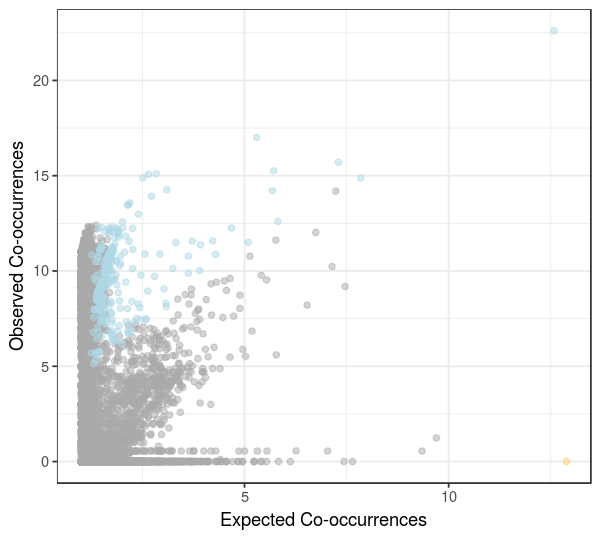

In [135]:
# plotting occurrences
p = ggplot(cooccur_res_pt_s, aes(exp_cooccur, obs_cooccur)) + 
    geom_point(data=cooccur_res_pt_s %>% filter(sign==0), alpha=0.5, color="dark gray") +
    geom_point(data=cooccur_res_pt_s %>% filter(sign==-1), alpha=0.5, color="#FFCC66") +
    geom_point(data=cooccur_res_pt_s %>% filter(sign==1), alpha=0.5, color="light blue") +
    labs(x="Expected Co-occurrences", y="Observed Co-occurrences") +
    theme_bw()

options(repr.plot.width=5, repr.plot.height=4.5)
plot_write(p, file='IndD-sens_OTU-binom_exp-obs.pdf')

In [124]:
# Summarizing by phylum
cooccur_res_pt_s_s = cooccur_res_pt_s %>%
    group_by(Phylum.x, Phylum.y) %>%
    mutate(n_edges = n()) %>%
    group_by(Phylum.x, Phylum.y, sign) %>%
    summarize(perc_of_edges = n() / first(n_edges) * 100) %>%
    ungroup() 

cooccur_res_pt_s_s %>% dfhead

[1] 48  4


Phylum.x,Phylum.y,sign,perc_of_edges
Actinobacteria,Bacteroidetes,0,100.0000
Actinobacteria,Firmicutes,0,100.0000
Bacteroidetes,Bacteroidetes,0,99.0991


In [125]:
x1 = cooccur_res_pt_s_s %>%
    filter(sign != 0) %>%
    mutate(perc_of_edges = round(perc_of_edges, 2)) %>%
    arrange(sign, -perc_of_edges)

x1

Phylum.x,Phylum.y,sign,perc_of_edges
Proteobacteria,Proteobacteria,-1,0.84
Proteobacteria,Proteobacteria,1,5.88
Proteobacteria,Firmicutes,1,1.28
Firmicutes,Firmicutes,1,1.07
Firmicutes,Bacteroidetes,1,1.06
Bacteroidetes,Bacteroidetes,1,0.90
Proteobacteria,Bacteroidetes,1,0.40
Bacteroidetes,Firmicutes,1,0.30
Euryarchaeota,Firmicutes,1,0.24


### Normalizing by number of nodes

In [126]:
# getting unique OTUs (& taxonomy)
n_nodes = cooccur_res_pt_s %>%
    dplyr::select(sp1_name, sp2_name, Domain.x, Phylum.x, Domain.y, Phylum.y) %>%
    unite(Tax1, Domain.x, Phylum.x, sp1_name, sep=';') %>%
    unite(Tax2, Domain.y, Phylum.y, sp2_name, sep=';') 

n_nodes = c(n_nodes$Tax1 %>% as.vector %>% unique,
            n_nodes$Tax2 %>% as.vector %>% unique) %>%
    as.data.frame
colnames(n_nodes) = c('OTU')
n_nodes = n_nodes %>%
    separate(OTU, c('Domain', 'Phylum', 'OTU'), sep=';') %>%
    distinct() %>%
    group_by(Domain, Phylum) %>%
    summarize(n_OTUs = n()) %>%
    ungroup()

n_nodes %>% arrange(-n_OTUs)

Domain,Phylum,n_OTUs
Bacteria,Firmicutes,308
Bacteria,Bacteroidetes,54
Bacteria,Proteobacteria,21
Bacteria,Tenericutes,9
Archaea,Euryarchaeota,5
Bacteria,Cyanobacteria,4
Bacteria,Fusobacteria,3
Bacteria,Verrucomicrobia,2
Bacteria,Actinobacteria,1
Bacteria,Spirochaetae,1


In [127]:
cooccur_res_pt_s %>% dfhead

[1] 26848    24


sp1_name,sp2_name,obs_cooccur,prob_cooccur,exp_cooccur,q_gt,q_lt,sign,Domain.x,Phylum.x,⋯,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,sd_effects,effects
003c4ae8c3fbf5aee27b58e6b7fd5e10,0215b7637847641274246f9414d2b649,0,0.008870968,1.124194,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,unclassified,0.0009870516,-0.008782762
003c4ae8c3fbf5aee27b58e6b7fd5e10,09aa18b6829bdca56e6f9aff75f581dd,0,0.008675676,1.097297,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0007476836,-0.008572635
003c4ae8c3fbf5aee27b58e6b7fd5e10,1b5fb6f4fd4f5e63f7bb4b6d9e1d40e8,8,0.008125000,1.062500,0.92,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0005812686,0.054199219


In [128]:
# percent of nodes in taxonomic groups
x2 = cooccur_res_pt_s %>%
    inner_join(n_nodes, c('Phylum.x'='Phylum')) %>%
    inner_join(n_nodes, c('Phylum.y'='Phylum')) %>%
    group_by(Phylum.x, Phylum.y, sign) %>%
    summarize(edges_norm = n() / (first(n_OTUs.x) + first(n_OTUs.y))) %>%
    ungroup() %>%
    filter(sign != 0) %>%
    mutate(edges_norm = round(edges_norm, 3)) %>%
    arrange(sign, -edges_norm)

x2 

Warning message:
“Column `Phylum.x`/`Phylum` joining factor and character vector, coercing into character vector”Warning message:
“Column `Phylum.y`/`Phylum` joining factor and character vector, coercing into character vector”

Phylum.x,Phylum.y,sign,edges_norm
Proteobacteria,Proteobacteria,-1,0.024
Firmicutes,Firmicutes,1,0.276
Proteobacteria,Proteobacteria,1,0.167
Proteobacteria,Firmicutes,1,0.112
Bacteroidetes,Firmicutes,1,0.039
Bacteroidetes,Bacteroidetes,1,0.037
Proteobacteria,Bacteroidetes,1,0.027
Firmicutes,Bacteroidetes,1,0.014
Euryarchaeota,Firmicutes,1,0.003


### Combined table

In [129]:
# both tables
x1 %>%
    full_join(x2, c('Phylum.x', 'Phylum.y', 'sign'))

Warning message:
“Column `Phylum.x` joining factor and character vector, coercing into character vector”Warning message:
“Column `Phylum.y` joining factor and character vector, coercing into character vector”

Phylum.x,Phylum.y,sign,perc_of_edges,edges_norm
Proteobacteria,Proteobacteria,-1,0.84,0.024
Proteobacteria,Proteobacteria,1,5.88,0.167
Proteobacteria,Firmicutes,1,1.28,0.112
Firmicutes,Firmicutes,1,1.07,0.276
Firmicutes,Bacteroidetes,1,1.06,0.014
Bacteroidetes,Bacteroidetes,1,0.90,0.037
Proteobacteria,Bacteroidetes,1,0.40,0.027
Bacteroidetes,Firmicutes,1,0.30,0.039
Euryarchaeota,Firmicutes,1,0.24,0.003


## Saving network

In [130]:
# output file
ntwk_obj_file = file.path(work_dir, 'IndD-sens_OTU-binom_ntwk-tbl.RDS')
ntwk_obj_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-binom_ntwk-tbl.RDS"

In [131]:
# saving object
saveRDS(cooccur_res_pt_s, file=ntwk_obj_file)
cat('File written:', ntwk_obj_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/cooccur//IndD-sens_OTU-binom_ntwk-tbl.RDS 


In [132]:
# re-loading object
cooccur_res_pt_s = readRDS(ntwk_obj_file)
cooccur_res_pt_s %>% dfhead

[1] 26848    24


sp1_name,sp2_name,obs_cooccur,prob_cooccur,exp_cooccur,q_gt,q_lt,sign,Domain.x,Phylum.x,⋯,Species.x,Domain.y,Phylum.y,Class.y,Order.y,Family.y,Genus.y,Species.y,sd_effects,effects
003c4ae8c3fbf5aee27b58e6b7fd5e10,0215b7637847641274246f9414d2b649,0,0.008870968,1.124194,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,unclassified,0.0009870516,-0.008782762
003c4ae8c3fbf5aee27b58e6b7fd5e10,09aa18b6829bdca56e6f9aff75f581dd,0,0.008675676,1.097297,1.00,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0007476836,-0.008572635
003c4ae8c3fbf5aee27b58e6b7fd5e10,1b5fb6f4fd4f5e63f7bb4b6d9e1d40e8,8,0.008125000,1.062500,0.92,1,0,Bacteria,Tenericutes,⋯,,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,uncultured,unclassified,0.0005812686,0.054199219


# sessionInfo

In [133]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_eco/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
 [4] future_1.8.1            cooccur_1.3             networkD3_0.4          
 [7] phyloseq_1.22.3         ggplot2_3.0.0           tidyr_0.8.1            
[10] dplyr_0.7.6            

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0      jsonlite_1.5        splines_3.4.1      
 [4] foreach_1.4.4       assertthat_0.2.0    stats4_3.4.1       
 [7] base64url_1.4       progress_1.2.0      globals_0.12.1     
[10] backports_1.1.2     pillar